This notebook implements the Transformer architecture from scratch using PyTorch, following the original "Attention Is All You Need" paper by Vaswani et al. The implementation avoids using high-level APIs (like `torch.nn.Transformer`) to give a deeper understanding of the model’s internal mechanics.

## Objectives
- Understand the architecture of the Transformer.
- Build each component from scratch:
  - Positional Encoding
  - Scaled Dot-Product Attention
  - Multi-Head Attention
  - Feedforward Networks
  - Encoder and Decoder Layers
  - Full Transformer Model



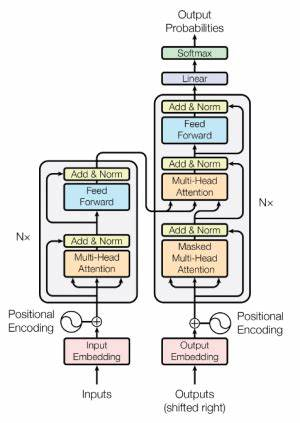

# Load dependencies

In [2]:
import requests
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(22)

In [3]:
cfg = {
    "context_size": 5,
    "vector_dimension": 100,
    "batch_size": 8,
    "stride": 4,
    "num_heads_per_attention_layer": 4,
    "drop_rate": 0.1
}

# 1. Data Preparation

## 1.1. Load the data

In [4]:
# URL of the plain text file
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

In [5]:
response = requests.get(url)
text = response.text
text = text.lstrip('\ufeff')   # This will remove the Byte Order Mark (BOM) as "\ufeff"

print("The number of characters:",len(text))
print(text[:500])

The number of characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it'


## 1.2. Tokenize the data

In [5]:
class SimpleTokenizer:
  def __init__(self, text):

    tokens = self.__tokenize(text)
    all_words = sorted(set(tokens))

    # Adding Special Tokens
    # - <UNK> -> Handling out-of-vocabulary words
    # - (BOS) -> Put in begenning of each document
    # - (EOS) -> Put in end of each document
    # - Padding (BAD) -> Handling unequal sentences in length
    all_words.extend(('<UNK>','<BOS>','<EOS>','<PAD>'))

    self.voc_str_int = {word: i for i, word in enumerate(all_words)}
    self.voc_int_str = {i: word for i, word in enumerate(all_words)}

  def __tokenize(self, text):

    tokens = re.split(r'([,.?_!"()\':;]|--|\s)', text)

    tokens = [token.strip() for token in tokens if token.strip()]

    return tokens

  def encode(self, text):

    tokens = self.__tokenize(text)

    ids = [self.voc_str_int.get(token, self.voc_str_int['<UNK>']) for token in tokens]

    return ids

  def decode(self, ids):

    tokens = [self.voc_int_str.get(id, '<UNK>') for id in ids]

    text = ' '.join(tokens)

    text = re.sub(r'\s+([,.?_!"()\':;]|--|\s)', r'\1', text) # Remove spaces before this specified characters (eg. ,.?)

    return text

  def __len__(self):
    return len(self.voc_str_int)

## 1.3. Data Loader

In [14]:
class SimpleDataLoader:
  def __init__(self, token_ids, context_size=4, batch_size=1, stride=1):
    self.context_size = context_size
    self.batch_size = batch_size
    self.stride = stride

    self.X, self.Y = self.__create_dataset(token_ids)

  def __create_dataset(self, token_ids):
    X, Y = [], []
    for i in range(0, len(token_ids) - self.context_size - 1, self.stride):
      x = token_ids[i : i + self.context_size]
      y = token_ids[i + 1 : i + self.context_size + 1]

      if len(y) == self.context_size:
        X.append(x)
        Y.append(y)

    return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

  def __len__(self):
    return len(self.X) // self.batch_size

  def __getitem__(self, idx):
    start = idx * self.batch_size
    end = start + self.batch_size
    return self.X[start:end], self.Y[start:end]

## 1.4. Token Embeddings

In [15]:
# Tokenizer
tokenizer = SimpleTokenizer(text)
token_ids = tokenizer.encode(text)

# Data Loader
dataloader = SimpleDataLoader(token_ids, cfg["context_size"], cfg["batch_size"], cfg["stride"])
x_batch, y_batch = dataloader[0]

print("X:", x_batch[0])
print("Y:", y_batch[0])

# Embedding Layer
cfg['vocabulary_size'] = len(tokenizer)
embedding_layer = nn.Embedding(cfg['vocabulary_size'], cfg["vector_dimension"])

print(embedding_layer(x_batch[0]), "\n\n")  # Embedding vectors of the input for the fisrt sample (5 * 100)
print(embedding_layer(y_batch[0])) # Embedding vectors of the output for the fisrt sample (5 * 100)

x_token_embedding = embedding_layer(x_batch)  # Embedding vectors of the input for the fisrt sample (5 * 100)
y_token_embedding = embedding_layer(y_batch) # Embedding vectors of the output for the fisrt sample (5 * 100)

X: tensor([  53,   44,  149, 1003,   57])
Y: tensor([  44,  149, 1003,   57,   38])
tensor([[ 1.1643e-01, -8.9863e-01, -8.0650e-01, -2.1209e-01,  7.0207e-01,
          1.3050e+00,  6.0570e-01,  3.2250e-01, -1.9055e-01, -1.6184e+00,
         -1.0426e+00,  6.2991e-01,  1.7805e-02,  1.1292e-01,  1.2092e+00,
         -1.1995e+00, -5.2005e-01,  5.7953e-01, -3.3052e-01,  1.2906e-01,
          3.2937e-01,  3.9831e-01, -7.0954e-01, -7.2398e-01, -1.0799e+00,
          1.2437e+00,  3.5026e-01,  1.0935e+00,  6.3276e-02,  5.8337e-01,
          2.0401e+00,  8.8610e-01, -5.5435e-01, -1.9187e-02, -9.0124e-01,
          1.0031e+00,  5.2943e-01,  1.2198e+00, -1.6112e+00, -1.5472e+00,
         -1.2486e+00,  2.8354e-01, -3.8003e-01, -1.0258e+00,  2.8071e-01,
          1.3916e+00,  1.0995e+00, -1.6832e+00, -9.3710e-01, -5.5004e-01,
         -1.1343e+00,  2.2370e-01, -3.5185e-01,  7.7926e-01, -1.0793e+00,
          1.1477e+00, -5.6273e-01,  1.9471e+00,  1.1578e+00, -2.8151e-01,
         -4.6778e-01, -1.149

## 1.5. Positional values

In [16]:
# Positional Embedding Layer
position_layer = nn.Embedding(cfg["context_size"], cfg["vector_dimension"])

# Generate position indices: shape (context_size,)
position_emb = position_layer(torch.arange(cfg["context_size"]))

# Add position encoding
position_encoded_values = x_token_embedding + position_emb

# Print first sample
print(position_encoded_values[0])

tensor([[ 1.3414e+00, -6.1298e-01, -1.5133e-01,  2.4923e+00,  6.2833e-01,
          1.1008e+00, -9.6310e-02,  2.3982e+00,  7.5440e-01, -6.5913e-01,
         -8.0341e-01,  1.0202e+00, -2.5736e+00, -2.9641e-01,  1.5974e+00,
         -2.1826e+00, -1.3095e+00,  3.2265e-01, -1.1026e+00, -5.3272e-01,
         -3.1154e-01,  1.4763e+00, -2.1763e-01, -1.3103e+00, -1.9795e+00,
          1.9737e+00, -7.9875e-01,  2.3525e-01,  3.0193e-01, -5.5687e-01,
          1.0759e+00, -1.6970e+00,  1.6060e-03,  4.2491e-02,  3.1297e-01,
          1.3292e+00, -7.1036e-01,  9.3197e-01, -1.7344e+00, -1.1302e+00,
         -1.1187e-01,  1.6770e+00, -2.5211e-01, -4.1604e-01,  7.4394e-01,
          2.8277e+00,  1.9688e+00, -3.4637e+00, -4.5261e-01, -6.9302e-01,
         -3.5045e+00,  9.3738e-01, -1.4675e+00,  8.2923e-01, -2.0252e+00,
          1.0453e+00, -1.6178e+00,  8.4702e-01,  1.6471e+00, -1.5013e+00,
         -2.8082e-01, -2.5207e+00,  1.9079e-02, -2.1736e+00, -5.1891e-03,
         -2.1646e+00, -2.6537e-01, -2.

# 2. Multi-Head Attention with weights splits

## 2.1. Self attention mechanism with query, key, and value matrices

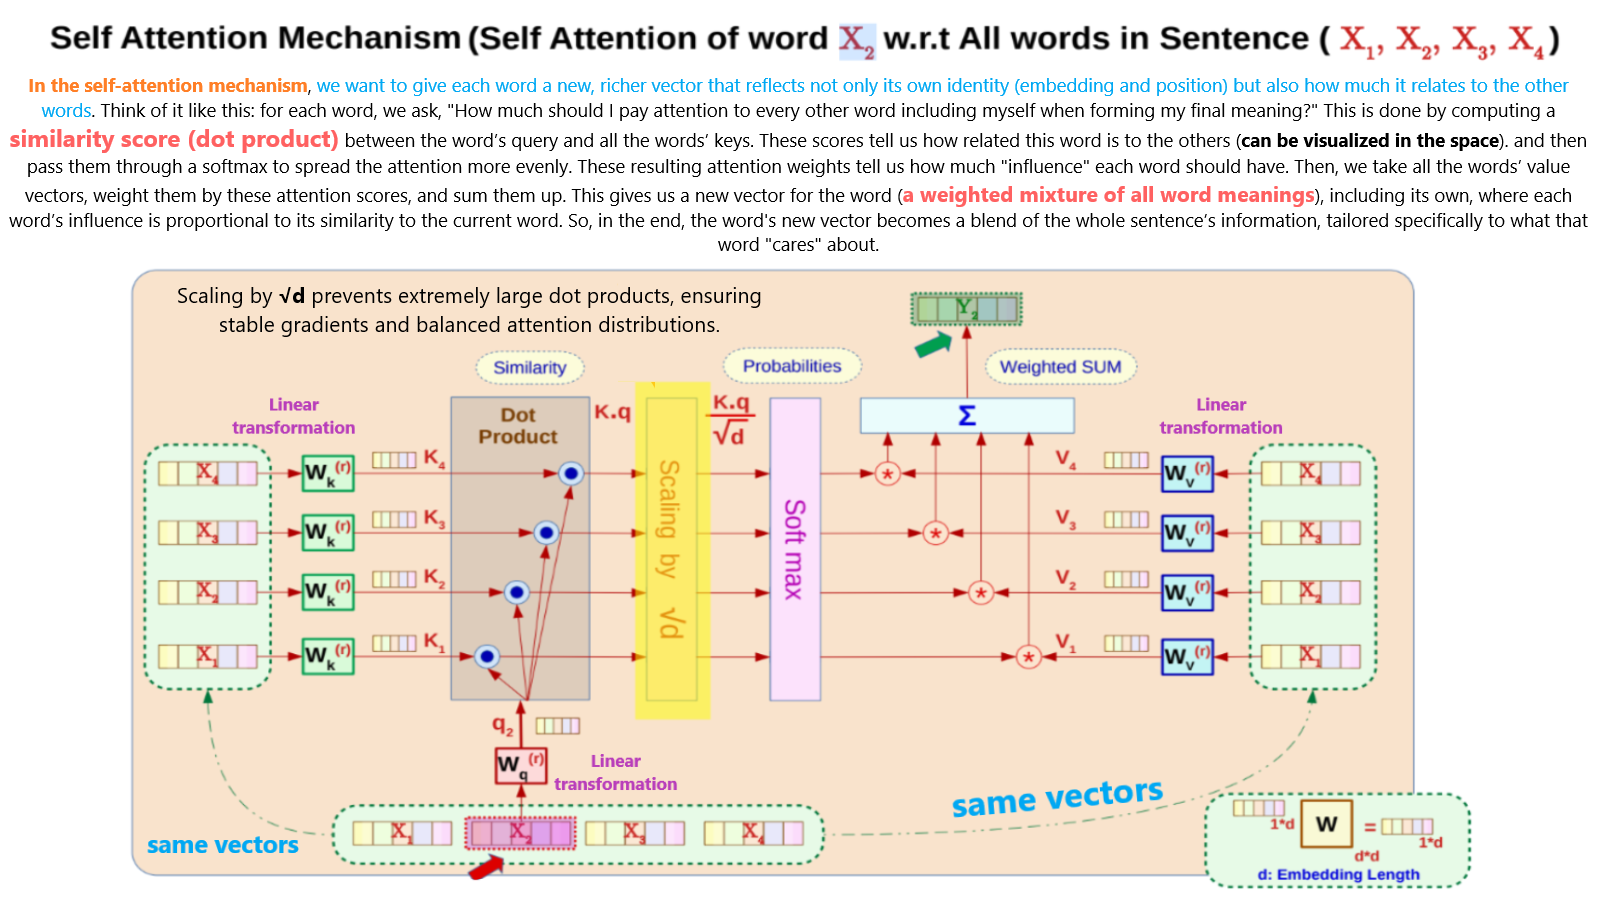

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, vector_dim, output_dim, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.vector_dim = vector_dim    # Dimension of input embeddings
        self.output_dim = output_dim  # Dimension of Q, K, V, and final output
        self.num_heads = num_heads
        self.head_dim = output_dim // num_heads  # Dimension per head

        # Linear projections
        self.query = nn.Linear(vector_dim, output_dim)
        self.key   = nn.Linear(vector_dim, output_dim)
        self.value = nn.Linear(vector_dim, output_dim)

        # Final output projection
        self.out_proj = nn.Linear(output_dim, output_dim)

    def forward(self, x):
        Batch, context_size, _ = x.shape  # (Batch, context_size, vector_dim)

        # Linear projections (Batch, context_size, vector_dim) * (vector_dim, output_dim) = (Batch, context_size, output_dim)
        Queries = self.query(x)
        Keys    = self.key(x)
        Values  = self.value(x)

        # Reshape for multi-head: (Batch, context_size, output_dim) → (Batch, num_heads, context_size, head_dim)
        Queries = Queries.view(Batch, context_size, self.num_heads, self.head_dim)
        Keys    = Keys.view(Batch, context_size, self.num_heads, self.head_dim)
        Values  = Values.view(Batch, context_size, self.num_heads, self.head_dim)

        # Transpose matrics from (Batch, context_size, num_heads, head_dim) to (Batch, num_heads, context_size, head_dim) to make each head alone
        Queries = Queries.transpose(1, 2)
        Keys    = Keys.transpose(1, 2)
        Values  = Values.transpose(1, 2)

        # Attention scores: (Batch, num_heads, context_size, head_dim) * (Batch, num_heads, head_dim, context_size) = (Batch, num_heads, context_size, context_size)
        AttentionScores = torch.matmul(Queries, Keys.transpose(-2, -1))

        # Scale attension scores and apply softmax to get attention weights
        AttentionWeights = F.softmax(AttentionScores / (self.head_dim ** 0.5), dim=-1)

        # Attention output (Batch, num_heads, context_size, context_size) * (Batch, num_heads, context_size, head_dim) = (Batch, num_heads, context_size, head_dim)
        Context = torch.matmul(AttentionWeights, Values)

        # Reverse transpose (Batch, context_size, num_heads, head_dim)
        Context = Context.transpose(1, 2)

        # Concatenate all heads (Batch, num_heads, context_size, head_dim) = (Batch, context_size, output_dim)
        Context = Context.contiguous().view(Batch, context_size, self.output_dim)

        # Final projection -> optional
        Output = self.out_proj(Context)  # (Batch, context_size, output_dim)

        return Output

## 2.2. Masked Multi-Head attention mechanism with query, key, and value matrices

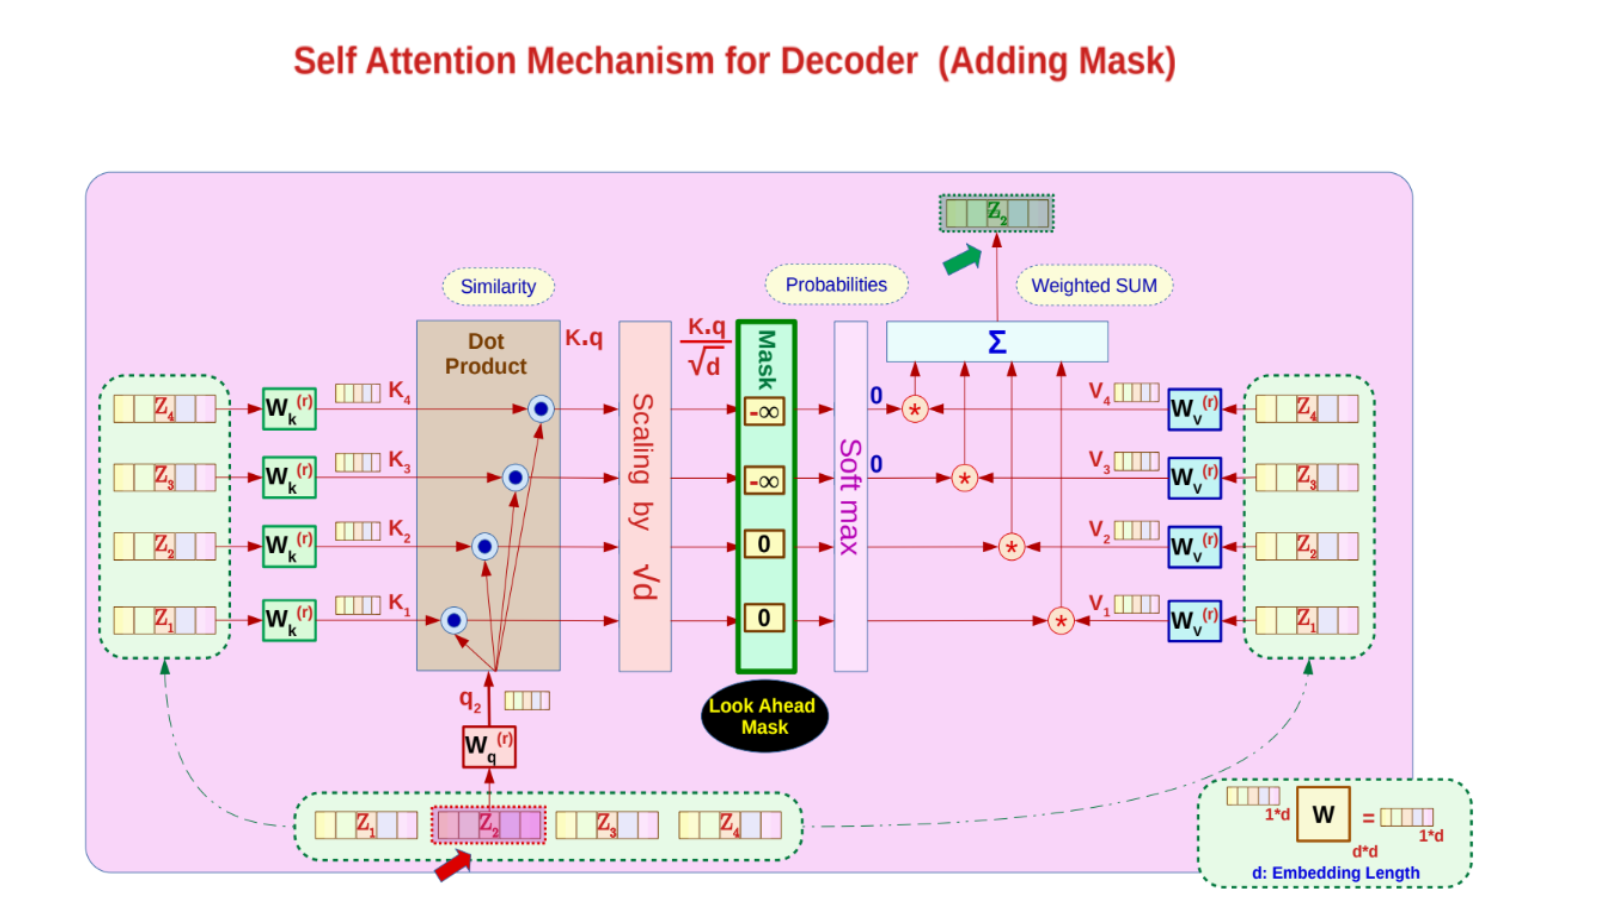

In [18]:
class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, vector_dim, output_dim, num_heads):
        super(MaskedMultiHeadAttention, self).__init__()

        self.vector_dim = vector_dim    # Dimension of input embeddings
        self.output_dim = output_dim    # Dimension of Q, K, V, and final output
        self.num_heads = num_heads
        self.head_dim = output_dim // num_heads  # Dimension per head

        # Linear projections
        self.query = nn.Linear(vector_dim, output_dim)
        self.key   = nn.Linear(vector_dim, output_dim)
        self.value = nn.Linear(vector_dim, output_dim)

        # Final output projection
        self.out_proj = nn.Linear(output_dim, output_dim)

        # Causal mask: upper-triangular matrix filled with -inf (except diagonal and below)
        self.register_buffer("causal_mask", torch.tril(torch.ones(1000, 1000)).unsqueeze(0).unsqueeze(0))  # (1, 1, max_context, max_context)

    def forward(self, x):
        Batch, context_size, _ = x.shape  # (Batch, context_size, vector_dim)

        # Linear projections: (Batch, context_size, vector_dim) * (vector_dim, output_dim) = (Batch, context_size, output_dim)
        Queries = self.query(x)
        Keys    = self.key(x)
        Values  = self.value(x)

        # Reshape: (Batch, context_size, output_dim) → (Batch, context_size, num_heads, head_dim)
        Queries = Queries.view(Batch, context_size, self.num_heads, self.head_dim)
        Keys    = Keys.view(Batch, context_size, self.num_heads, self.head_dim)
        Values  = Values.view(Batch, context_size, self.num_heads, self.head_dim)

        # Transpose to (Batch, num_heads, context_size, head_dim)
        Queries = Queries.transpose(1, 2)
        Keys    = Keys.transpose(1, 2)
        Values  = Values.transpose(1, 2)

        # Compute attention scores: (Batch, num_heads, context_size, head_dim) * (Batch, num_heads, head_dim, context_size) = (Batch, num_heads, context_size, context_size)
        AttentionScores = torch.matmul(Queries, Keys.transpose(-2, -1))

        # Apply causal mask: (Batch, num_heads, context_size, context_size)
        mask = self.causal_mask[:, :, :context_size, :context_size]  # crop mask to match context_size
        AttentionScores = AttentionScores.masked_fill(mask == 0, float('-inf'))

        # Scale and apply softmax
        AttentionWeights = F.softmax(AttentionScores / (self.head_dim ** 0.5), dim=-1)

        # Weighted sum: (Batch, num_heads, context_size, context_size) * (Batch, num_heads, context_size, head_dim) = (Batch, num_heads, context_size, head_dim)
        Context = torch.matmul(AttentionWeights, Values)

        # Transpose back: (Batch, context_size, num_heads, head_dim)
        Context = Context.transpose(1, 2)

        # Concatenate heads: (Batch, context_size, num_heads * head_dim) = (Batch, context_size, output_dim)
        Context = Context.contiguous().view(Batch, context_size, self.output_dim)

        # Final output projection
        Output = self.out_proj(Context)  # (Batch, context_size, output_dim)

        return Output

In [19]:
multihead_att = MaskedMultiHeadAttention(cfg["vector_dimension"], cfg["vector_dimension"], cfg["num_heads_per_attention_layer"])
output = multihead_att(position_encoded_values)

print(output.shape)
print(output[:2, :, :10])

torch.Size([8, 5, 100])
tensor([[[-0.0371,  0.3017,  0.9281, -0.3953,  0.7606, -0.1408,  0.1070,
           0.1410,  0.6512, -0.1581],
         [ 0.3580,  0.0950,  0.0487, -0.1659, -0.0627,  0.1469,  0.1171,
           0.5125,  0.8994, -0.2566],
         [ 0.2329,  0.3396, -0.0253, -0.0256, -0.0199, -0.1079,  0.0444,
           0.2488,  0.3451,  0.0895],
         [ 0.0145,  0.2524, -0.0127,  0.1469, -0.0565,  0.0724, -0.0332,
           0.5057,  0.5107,  0.0361],
         [-0.0807,  0.3001,  0.0765, -0.1420,  0.3483,  0.0645, -0.1547,
           0.0451,  0.2064,  0.0014]],

        [[-0.5232,  0.4089,  0.0581, -0.2642,  0.5509,  0.3466,  0.2866,
           0.6043,  0.1501, -0.0355],
         [-0.2166,  0.3694, -0.1526, -0.2249,  0.4855, -0.0542,  0.2848,
           0.4877,  0.4042,  0.0662],
         [ 0.1915,  0.3498, -0.2645, -0.1953,  0.0411, -0.1297,  0.1980,
           0.2840,  0.2226,  0.0468],
         [ 0.2311,  0.5074, -0.0687, -0.0330,  0.5300,  0.1900,  0.0893,
           0.

# 3. Layer Normalization

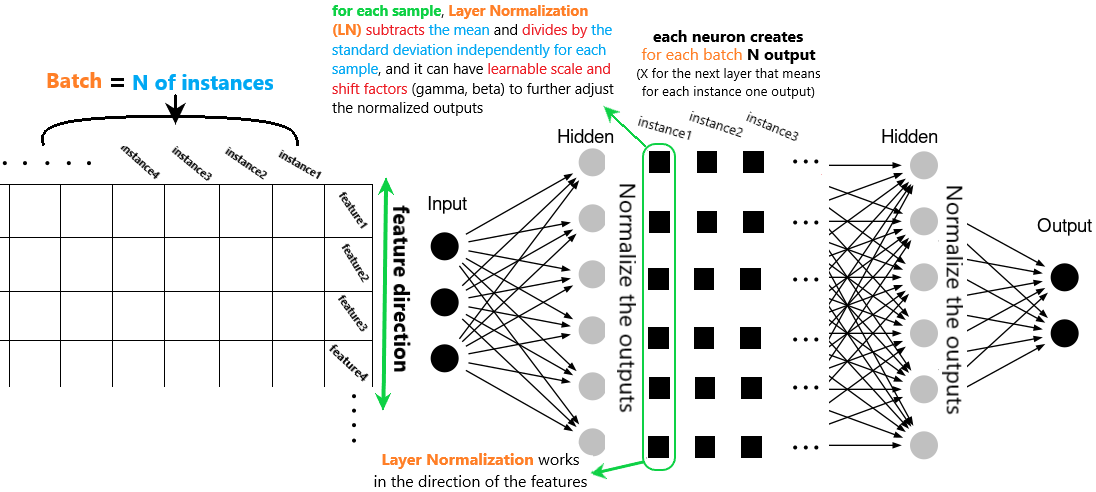

In [20]:
class LayerNorm(nn.Module):
  def __init__(self, vecotr_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(vecotr_dim))
    self.shift = nn.Parameter(torch.zeros(vecotr_dim))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    std = x.std(dim = -1, keepdim = True)
    norm_x = (x - mean) / (std + self.eps)

    return self.scale * norm_x + self.shift # This allows the model to learn appropriate scaling and shifting that best suit the data

# 4. Feedforward network with Gelu activation function

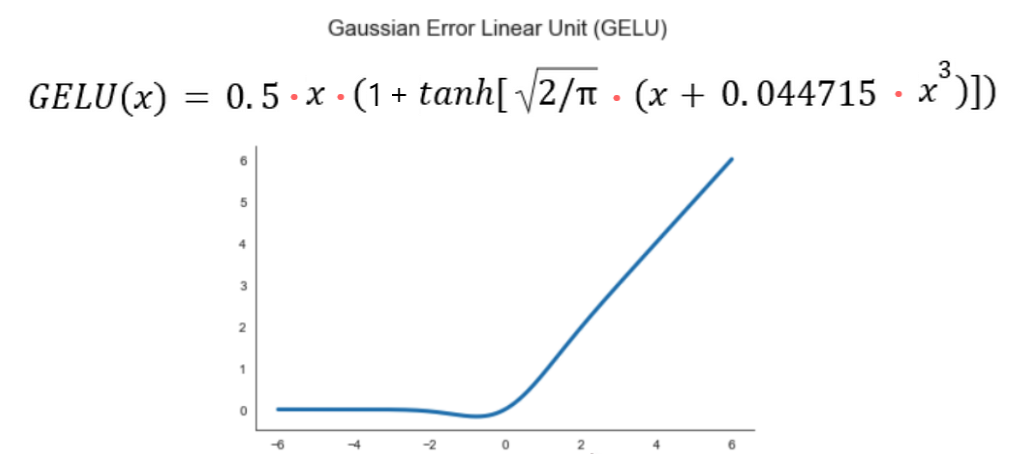

In [21]:
class Gelu(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2 / torch.pi)) *
             (x + 0.044715 * torch.pow(x, 3))
             )
          )

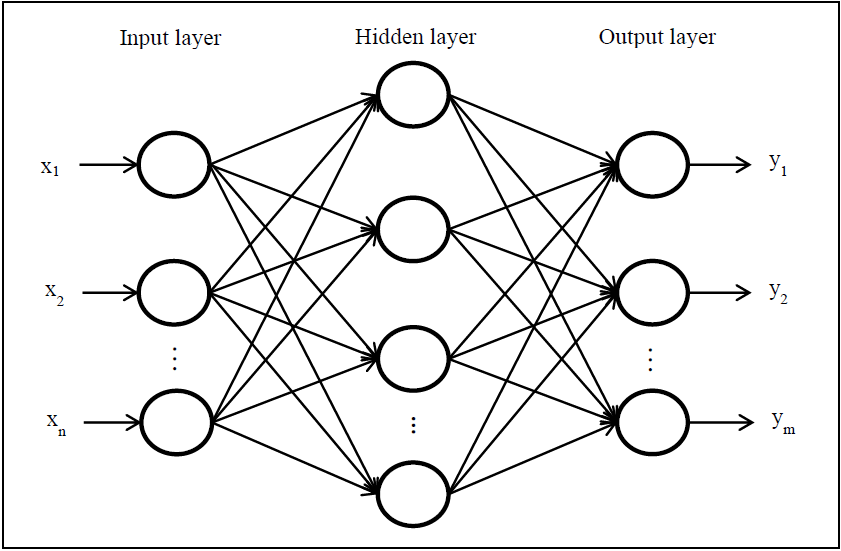

In [22]:
class FeedForward(nn.Module):
  def __init__(self, vector_dim):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(vector_dim, 4 * vector_dim),
        Gelu(),
        nn.Linear(4 * vector_dim, vector_dim),
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super(TransformerBlock, self).__init__()
    # Embedding layer
    self.embedding_layer = nn.Embedding(cfg['vocabulary_size'], cfg["vector_dimension"])
    # Positional layer
    self.position_layer = nn.Embedding(cfg["context_size"], cfg["vector_dimension"])

    # Dropout layer
    self.drop_layer = nn.Dropout(cfg["drop_rate"])

    # Multi-head attention layer
    self.multihead_att = MaskedMultiHeadAttention(cfg["vector_dimension"],
                                                  cfg["vector_dimension"],
                                                  cfg["num_heads_per_attention_layer"]
                                                  )
    # Norm layer
    self.Norm_layer = nn.LayerNorm(cfg["vector_dimension"])

    # Linear layer that recieves input dimension of vector_dimension and output vocabulary_size
    self.out_head = nn.Linear(cfg["vector_dimension"], cfg["vocabulary_size"], bias = False)


  def forward(self, in_idx):
    # Embedding vectors of the input
    token_embedding = self.embedding_layer(x_batch)

    # Generate position indices: shape (context_size,)
    position_embedding = self.position_layer(torch.arange(cfg["context_size"], device=in_idx.device))

    # Add position encoding
    position_encoded_values = token_embedding + position_embedding

    # Apply dropout layer
    x = self.drop_layer(position_encoded_values)

    # Apply multi-head attention
    x = self.multihead_att(x)

    # Apply normalization
    x = self.Norm_layer(x)

    logits = self.out_head(x)

    return logits

In [25]:
torch.manual_seed(22)

batch_example = torch.randn(2, 5)

layer = nn.Sequential(
    nn.Linear(5, 6),
    nn.ReLU()
)

out = layer(batch_example)
print(out)

layernorm = LayerNorm(5)
out = layernorm.forward(batch_example)
print(out)

ff_layer = FeedForward(5)
out = ff_layer.forward(batch_example)
print(out)

tensor([[0.8152, 0.4974, 1.3661, 0.0000, 1.3241, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5149, 0.0000, 0.7819]],
       grad_fn=<ReluBackward0>)
tensor([[ 0.7354, -0.1417,  0.0897,  0.9227, -1.6061],
        [-0.6556,  0.6345,  0.2168, -1.3431,  1.1474]], grad_fn=<AddBackward0>)
tensor([[ 1.3064,  0.2492,  0.2487,  1.2594,  0.3326],
        [ 0.1844,  0.2776,  0.1598, -0.1200, -0.4533]], grad_fn=<MulBackward0>)
